# IBM 推荐系统

数据：IBM开发者社区 Blog数据

## 目录

I. [探索性数据分析](#Exploratory-Data-Analysis)<br>
II.[基于排名的推荐方法](#Rank)<br>
III.[基于用户-用户的协同过滤](#User-User)<br>
IV.[基于内容的推荐方法（选修内容）](#Content-Recs)<br>
V. [矩阵分解](#Matrix-Fact)<br>
VI.[其他内容和总结](#conclusions)


In [1]:
! pip install progressbar

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">第一部分：探索性数据分析</a>


`1.` 用户与数据集中的多少篇文章互动了？分布如何？以图表的形式描述每个用户与某篇文章互动的次数。

#### 用户维度-互动次数统计

In [4]:
df_groupby_user = df.groupby('email')['article_id'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) # .head(5)
df_groupby_user.head(5)

,email,count
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


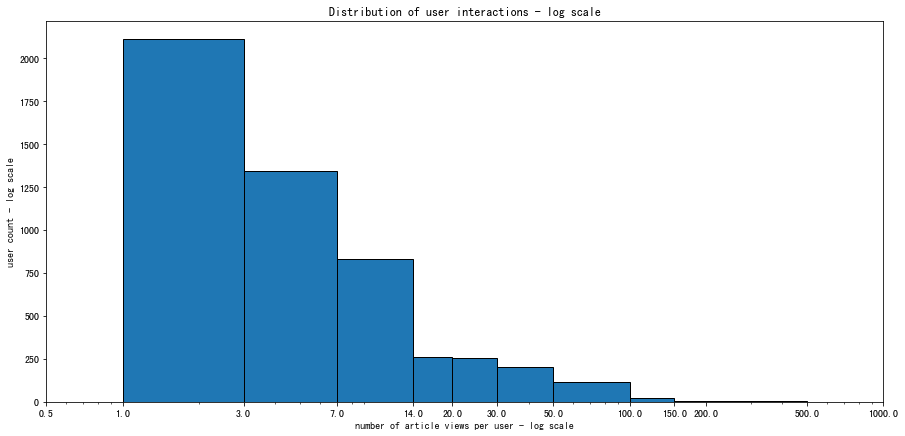

In [5]:
hist_bins = [0,1,3,7,14,20,30,50,100,150,200,500]
hist_ticks = np.array([0.5, 1,3,7,14,20,30,50,100,150,200,500,1000])
plt.figure(figsize=(15,7))
# plt.hist(df[['email','article_id']].groupby(['email']).count()['article_id'],bins=hist_bins,histtype='bar',ec='black')
plt.hist(df_groupby_user['count'], bins=hist_bins, histtype='bar', ec='black')
plt.yscale('linear')
plt.xscale('log')
plt.xticks(hist_ticks,hist_ticks.astype(str))
plt.title('Distribution of user interactions - log scale')
plt.xlabel('number of article views per user - log scale')
plt.ylabel('user count - log scale')
plt.show()

#### 文章维度-互动次数统计

In [6]:
df_groupby_article = df.groupby('article_id')['title'].count() \
                                .reset_index(name='count') \
                                .sort_values(['count'], ascending=False)
df_groupby_article.head(5)

,article_id,count
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [7]:
# Fill in the median and maximum number of user_article interactios below
# round(df.shape[0]/df['email'].nunique()) 
median_val = df_groupby_user.quantile([.5])['count'].values[0] # 50% of individuals interact with _9_ number of articles or fewer.
max_views_by_user = df_groupby_user.head(1)['count'].values[0] # The maximum number of user-article interactions by any 1 user is _364_.
print(f"median_val: {median_val}\nmax_views_by_user: {max_views_by_user}")


median_val: 3.0
max_views_by_user: 364


`2.` 发现并移除 **df_content** dataframe 中的重复文章。

In [8]:
# Find and explore duplicate articles
# 查看重复文章
df_content[df_content['article_id'].duplicated()==True]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# 源数据集上删除重复文章
print('Number of sample before removing duplicates: {}'.format(df_content.shape[0]))
df_content.drop_duplicates('article_id', inplace=True, keep='first')
print('Number of sample before removing duplicates: {}'.format(df_content.shape[0]))

Number of sample before removing duplicates: 1056
Number of sample before removing duplicates: 1051


`3.` 数据统计：

**a.**用户与之互动的唯一文章数量。  
**b.**数据集中的唯一文章数量（无论用户是否与之互动了）。<br>
**c.**数据集中的唯一用户数量。（不包括空值）<br>
**d.**数据集中的用户-文章互动次数。

In [10]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique() # The number of unique articles on the IBM platform
unique_users = df['email'].nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions
print(f"用户与之互动的唯一文章数量: {unique_articles}\n唯一文章数量: {total_articles}\n唯一用户数量: {unique_users}\n用户-文章互动次数: {user_article_interactions}")

用户与之互动的唯一文章数量: 714
唯一文章数量: 1051
唯一用户数量: 5148
用户-文章互动次数: 45993


`4.` 查看次数最多的文章的 **article_id**，以及被查看频率。我们将email信息映射成user_id

In [11]:
most_viewed_article_id = str(df_groupby_article['article_id'].values[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df_groupby_article['count'].values[0] # The most viewed article in the dataset was viewed how many times?
print(f"most_viewed_article_id: {most_viewed_article_id}\nmax_views: {max_views}")

most_viewed_article_id: 1429.0
max_views: 937


In [12]:
# map email to user_id
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">第二部分：基于排名的推荐方法</a>

我们没有关于用户是否喜欢某篇文章的评分。只知道用户与文章互动了。所以，文章的热门程度只能通过用户与文章的互动频率来判断。

`1.` 按照互动次数从高到低排序，返回前 **n** 篇文章。

In [14]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # group by [article_id, user_id]
    df_groupby_article = df.groupby('article_id')['user_id'].count() \
                                .reset_index(name='count') \
                                .sort_values(['count'],ascending=False)
    # top_article_idx = df_groupby_article.head(n).index
    article_ids = df_groupby_article.head(n)['article_id'] # .apply(lambda x: int(x))
    top_articles = list(set(df[df['article_id'].isin(list(article_ids))]['title']))
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # group by [article_id, user_id]
    df_groupby_article = df.groupby('article_id')['user_id'].count() \
                                .reset_index(name='count') \
                                .sort_values(['count'],ascending=False)
    top_articles = list(df_groupby_article.head(n)['article_id'].values) 
    
    return top_articles # Return the top article ids

In [15]:
print(get_top_articles(5))
print(get_top_article_ids(5))

['insights from new york car accident reports', 'use deep learning for image classification', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]


### <a class="anchor" id="User-User">第三部分：基于用户-用户的协同过滤</a>


`1.` 调整 **df** dataframe 的形状，使行表示用户，并使列表示文章。  

* 每个**用户**只能在每**行**中出现一次。

* 每篇**文章**只能在每**列**中出现一次。  


* **如果用户与某篇文章互动了，则在该文章所在的列与用户行形成的单元格中填充 1**。无论用户与文章互动了多少次，都填充 1。  


* **如果用户与文章没有互动，则在该文章所在的列与用户行形成的单元格中填充 0**。 


In [17]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # 构建矩阵
    user_item = df.groupby(['user_id', 'article_id'])['article_id'].count().unstack()
    user_item = user_item.fillna(0)
    for col in user_item.columns.values:
        user_item[col] = user_item[col].apply(lambda x: x if x == 0 else 1)
    return user_item # return the user_item matrix 
    
    
    # 改变类型
    df['user_id'] = df['user_id'].astype('int64')
    df['article_id'] = df['article_id'].astype('int64')

    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack()
    # user_item.fillna(0)
    user_item[user_item.isnull() == False] = 1
    user_item[user_item.isnull() == True] = 0
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [18]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 如下函数，接受 user_id，并提供与该用户最相似的有序用户列表（从最相似到最不相似）。返回结果不包含提供的 user_id。用两个用户的点积表示相似性。 


In [20]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    n_users = user_item.shape[0]
    users_dist = []
    for user1 in range(1, n_users+1):
        dot_val = np.dot(user_item.loc[user_id], user_item.loc[user1])
        # 删除用户本身
        if user_id != user1:
            users_dist.append([user_id, user1, dot_val])
    
    # 用户-相似度 DataFrame
    df = pd.DataFrame(users_dist, columns=['user1', 'user2', 'dot_val'])
    # sort by similarity
    df = df.sort_values(by=['dot_val', 'user2'], ascending=False)
    # create list of just the ids
    
    similar_user_ids = df['user2'] # df.iloc[1:]['user2']
    most_similar_users = np.array(similar_user_ids)
    
    # remove the own user's id
    
       
    return most_similar_users # return a list of the users in order from most to least similar

`3.` 创建了为每个用户提供最相似用户的函数后，使用这些用户查找可以推荐的文章。`get_article_names` 返回向每个用户推荐的文章。

In [22]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # 获取文章名
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(set(df[df['user_id'] == user_id]['article_id']))
    article_names = get_article_names(article_ids, df=df)
    return article_ids, article_names # return the ids and names

def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = list() # np.array([])
    article_seen_ids, article_seen_names = get_user_articles(user_id, user_item=user_item)
    most_similar_users = find_similar_users(user_id)
    for neighbor in most_similar_users:
        neighbs_ids, neighbs_likes = get_user_articles(neighbor, user_item=user_item)
        new_recs = np.setdiff1d(neighbs_ids, article_seen_ids)
        # 更新recs # recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        recs.append(new_recs)
        recs = [item for sublist in recs for item in sublist]
        # recs.apply(lambda x: x.replace('\nName: title, dtype: object', ''))
        if len(recs) > m - 1:
            break
    recs = recs[:m]
    return recs # return your recommendations for this user_id    

In [23]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

`4.` 现在我们将提高上述 **user_user_recs** 函数的一致性。  

* 当所有用户与给定用户的邻近程度都一样时，先选择总互动次数最多的用户，然后选择互动次数第二多的用户。


* 当推荐的文章数量以低于 m 的数字开始并以高于 m的数字结束时，先选择总互动次数最多的文章，然后选择总互动次数第二多的文章。 上面的**top_articles** 函数获得这种排名。

In [25]:
# 用户分组统计 互动文章数量
df_groupby_u = df.groupby('user_id')['article_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) 
df_groupby_a = df.groupby('article_id')['user_id'].count().reset_index(name='count').sort_values(['count'], ascending=False)
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    n_users = user_item.shape[0]
    users_dist = []
    
    for neighbor_id in range(1, n_users+1):
        similarity = np.dot(user_item.loc[user_id], user_item.loc[neighbor_id])
        num_interactions = df_groupby_u[df_groupby_u['user_id']== neighbor_id]['count'].values[0]
        
        if user_id != neighbor_id:
            users_dist.append([neighbor_id, similarity, num_interactions])
    
    # 用户-相似度 DataFrame
    neighbors_df = pd.DataFrame(users_dist, columns=['neighbor_id', 'similarity', 'num_interactions'])
    # sort by similarity
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''    
    recs = np.array([])
    article_seen_ids, article_seen_names = get_user_articles(user_id, user_item=user_item)
    
    top_articles = get_top_article_ids(df['article_id'].nunique())
    
    for neighbor in get_top_sorted_users(user_id)['neighbor_id']:
        neighbs_ids, neighbs_likes = get_user_articles(neighbor, user_item=user_item)
        new_recs = np.setdiff1d(neighbs_ids, article_seen_ids)
        new_recs = np.intersect1d(top_articles, new_recs)
        # 更新recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m - 1:
            break
    recs = recs[:m]
    rec_names = get_article_names(list(recs[:m]))
    return recs, rec_names

`5.` 测试

In [27]:
### 测试
user1_most_sim = get_top_sorted_users(1).iloc[0][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9][0] # Find the 10th most similar user to user 131

In [28]:
user1_most_sim, user131_10th_sim

(3933.0, 242.0)

`6.` 如果是新用户，只能使用 **基于排名的推荐**，因为新用户，还没有互动信息，我们无法使用基于用户-用户的协同过滤推荐算法

`7.` 向新用户提供前 10 篇推荐文章。

In [30]:
new_user = '0.0'

# 前10文章ids
new_user_recs = get_top_article_ids(10, df=df) 
print(new_user_recs)


['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Content-Recs">第四部分：基于内容的推荐方法</a> 主要基于TFIDF计算文章相似性

内容可以是 **doc_body**、**doc_description** 或**doc_full_name**。 

**我选择了doc_description**

In [32]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [33]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
        
    return clean_tokens

df_content = df_content.dropna(subset=['doc_description'])

def make_article_tfidf(df_content=df_content):
    X = df_content.doc_description.values

    # Instantiate transformers and classifier
    vect = CountVectorizer(tokenizer=tokenize)
    tfidf = TfidfTransformer()

    # X classifier
    X_counts = vect.fit_transform(X)
    X_tfidf = tfidf.fit_transform(X_counts)
    
    articles_tfidf_array = X_tfidf.toarray()
    articles_tfidf_df = pd.DataFrame(articles_tfidf_array, index=df_content['article_id'])
    
    # 构造给定article
    
    return articles_tfidf_df

articles_tfidf_df = make_article_tfidf(df_content=df_content)
articles_tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.430378,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [34]:

def make_content_recs(article_id, n=5,df=articles_tfidf_df):
    '''
    INPUT:
    df: dataframe for each article tfidf value
    
    OUTPUT:
    article_id : article_id provide
    neighbor_id - is a neighbor article_id
    similarity - measure of the similarity of each user to the provided user_id
                    
    num_interactions = df_groupby_u[df_groupby_u['user_id']== neighbor_id]['count'].values[0]
    '''
    
    # 构造给定article_id 和其他所有article 相似度
    articles_sim = []
    for id1 in df.index:
        similarity = np.dot(df.loc[article_id], df.loc[id1])
        # num_interactions = df_groupby_a[df_groupby_a['article_id']== id1]['count'].values[0]
        articles_sim.append([article_id, id1, similarity])
    
    articles_sim_df = pd.DataFrame(articles_sim, columns=['article_id', 'neighbor_id', 'similarity'])
    articles_sim_df = articles_sim_df.sort_values(['similarity'], ascending=False)
    
    articles_sim_df['neighbor_id'] = articles_sim_df['neighbor_id'].astype('float64').apply(lambda x: str(x))
    
    article_names = get_article_names(list(articles_sim_df.iloc[1:]['neighbor_id'].values[:n]))
    return articles_sim_df, article_names



**基于doc_description相似性推荐流程**

1. 取出所有article的描述部分
2. 对每篇article的描述 计算向量 获取tfidf值
3. 对给定article_id ,计算与每篇文章的描述的tfidf值 计算点积。按点积排序，获取相近的article_id
4. 给出article_id, 获取推荐文章

`3.` 测试


In [35]:
articles_sim_df, article_names = make_content_recs(1)
print(f"文章1的推荐: {article_names}")
      
      
articles_sim_df, article_names = make_content_recs(1050)
print(f"文章1050的推荐: {article_names}")

文章1的推荐: ['data visualization playbook: telling the data story', 'declarative machine learning', 'data science bowl 2017', 'discover, catalog and govern data with ibm data catalog', 'the random forest algorithm ']
文章1050的推荐: ['using brunel in ipython/jupyter notebooks', 'why you should master r (even if it might eventually become obsolete)', 'a classification problem']


### <a class="anchor" id="Matrix-Fact">第五部分：矩阵分解</a>

利用矩阵分解向平台上的用户推荐文章。

`1.` 已经创建了 **user_item** 矩阵

In [38]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [39]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` 在此部分，你可以对用户-项目矩阵运用[numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) 的奇异值分解方法。在单元格中执行 SVD，并解释为何与课程中的步骤不一样。

In [40]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))


**Numpy的svd方法不支持NaN计算，user_item_matrix没有NaN值，所以可以直接计算**

`3.` 如何确定潜在特征的数量？当潜在特征的数量增加时，准确率会如何提高。

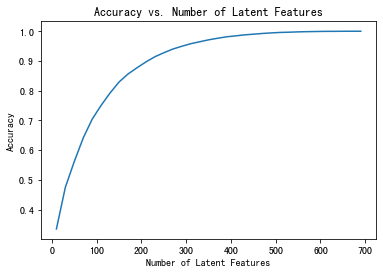

In [41]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` 通过上述单元格，我们无法判断要使用多少个潜在特征，因为能够更好地预测矩阵的 1 和 0 值，并不表明我们就能做出很好的推荐。将数据集划分为训练集和测试集。  

不同的潜在特征数量对训练集和测试集的准确率有何影响。 

* 我们可以对测试集中的多少个用户做出预测？  
* 由于冷启动问题，我们无法对多少个用户做出预测？
* 我们可以对测试集中的多少篇文章做出预测？  
* 由于冷启动问题，我们无法对多少篇文章做出预测？

In [42]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item_train[user_item_train.isnull() == False] = 1
    user_item_train[user_item_train.isnull() == True] = 0
    
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].max().unstack()
    user_item_test[user_item_test.isnull() == False] = 1
    user_item_test[user_item_test.isnull() == True] = 0
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [43]:
user_item_train.shape, user_item_test.shape, df.shape

((4487, 714), (682, 574), (45993, 3))

In [44]:
df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [45]:
# user_id 同时存在于 训练集df_train 和 测试集df_test 的数量
print("能预测的用户数量", len(np.intersect1d(df_test['user_id'], df_train['user_id'])))
print("不能-预测的用户数量", len(df_test['user_id'].unique()) -  len(np.intersect1d(df_test['user_id'], df_train['user_id'])))
print("能预测的文章数量", len(np.intersect1d(df_test['article_id'], df_train['article_id'])))
print("不能-能预测的文章数量", len(df_test['article_id'].unique()) - len(np.intersect1d(df_test['article_id'], df_train['article_id'])))

能预测的用户数量 20
不能-预测的用户数量 662
能预测的文章数量 574
不能-能预测的文章数量 0


`5.` SVD 在测试数据上做出推荐预测的效果如何。

np.in1d 测试

`test = np.array([0, 1, 2, 5, 0])
states = [0, 2]
mask = np.in1d(test, states)
mask -> array([ True, False,  True, False,  True])`

In [47]:
# 训练集的用户id 和文章id
train_idx = user_item_train.index.values
train_arts = user_item_train.columns.values

# 训练集 和 测试集 共有的用户 和文章 
test_user_subset = np.intersect1d(test_idx,train_idx)
test_articles_subset = np.intersect1d(test_arts,train_arts)

# 训练集中 用户 和 文章 (同时也在测试集中)
train_indexes = np.where(np.in1d(train_idx, test_user_subset))[0]
train_articles = np.where(np.in1d(train_arts, test_articles_subset))[0]

#测试s集中 用户 和 文章 (同时也在训练集中)
test_indexes = np.where(np.in1d(test_idx, test_user_subset))[0]

In [48]:
# fit SVD on the user_item_train matrix
## 矩阵列类型全部转换为int64类型
user_item_train = user_item_train.astype('int64')
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [49]:
# USER_ITEM矩阵的查找子集，仅包含通过训练和测试集共享的用户和文章
user_item_test_subset = user_item_test.iloc[test_indexes, :]
user_item_train_subset = user_item_train.iloc[train_indexes, train_articles]

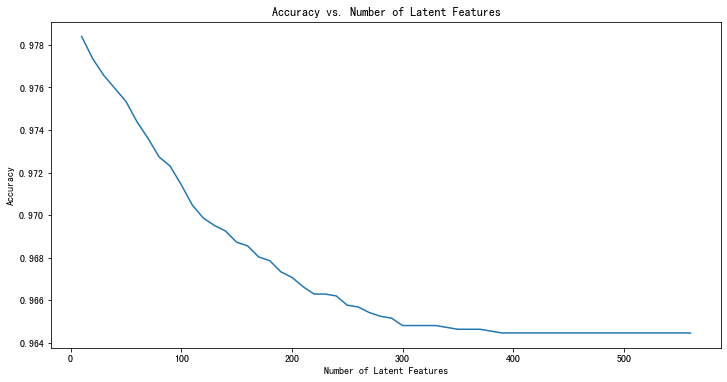

In [50]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

user_item_test = user_item_test.astype('int64')

num_latent_feats = np.arange(10,570,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # take dot product
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)

n_interactions_subset = user_item_test_subset.shape[0]*user_item_test_subset.shape[1]

plt.figure(figsize=(12, 6))
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/n_interactions_subset);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

预测值0、1 极度不平衡也是高精确度的原因